<a href="https://colab.research.google.com/github/gapac/ML_AI_examples/blob/main/Ga%C5%A1per_Jezernik_Workshop_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connect your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Go to /content/drive/MyDrive/Classroom/Delavnica/
2. Right click copy path to WorkshopDataset.zip
3. Insert path below!

In [ ]:
!unzip "/content/drive/MyDrive/workshop/WorkshopDataset.zip" -d "/content/"

Archive:  /content/drive/MyDrive/workshop/WorkshopDataset.zip
   creating: /content/WorkshopDataset/HGG/
   creating: /content/WorkshopDataset/HGG/Brats18_2013_10_1/
  inflating: /content/WorkshopDataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1.nii.gz  
  inflating: /content/WorkshopDataset/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii.gz  
   creating: /content/WorkshopDataset/HGG/Brats18_2013_11_1/
  inflating: /content/WorkshopDataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1.nii.gz  
  inflating: /content/WorkshopDataset/HGG/Brats18_2013_11_1/Brats18_2013_11_1_seg.nii.gz  
   creating: /content/WorkshopDataset/HGG/Brats18_2013_12_1/
  inflating: /content/WorkshopDataset/HGG/Brats18_2013_12_1/Brats18_2013_12_1.nii.gz  
  inflating: /content/WorkshopDataset/HGG/Brats18_2013_12_1/Brats18_2013_12_1_seg.nii.gz  
   creating: /content/WorkshopDataset/HGG/Brats18_2013_13_1/
  inflating: /content/WorkshopDataset/HGG/Brats18_2013_13_1/Brats18_2013_13_1.nii.gz  
  inflating: /content/Workshop

In [ ]:
!pip install SimpleITK

import os
import torch
import json

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np


root_dir = "/content/WorkshopDataset/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
class BrainImageDataset(Dataset):
  """
  Custom dataset class for handling brain image data.
  """
  def __init__(self, root_dir, transform=None):
    """
    Constructor method for initializing the dataset.

    Args:
        root_dir (str): Root directory where the images are stored.
        transform (callable, optional): Optional transformation to be applied to the images.
    """

    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    for folder in os.listdir(root_dir):
      for image_folder in os.listdir(root_dir + '/' + folder):
        path = root_dir + '/' + folder + '/' + image_folder
        self.image_paths.append(path)
  def __len__(self):
    """
    Method to return the total number of images in the dataset.
    """

    return len(self.image_paths)

  def __getitem__(self, idx):

    """
    Method to retrieve an image and its corresponding label given an index.

    Args:
        idx (int): Index of the image to retrieve.

    Returns:
        dict: A dictionary containing the image tensor, label tensor, and class tensor.
    """

    image_path = self.image_paths[idx]
    subject = image_path.split('/')[-1]
    image = sitk.ReadImage(image_path + '/' + subject + '.nii.gz')
    label = sitk.ReadImage(image_path + '/' + subject + '_seg.nii.gz')
    image = sitk.GetArrayFromImage(image)
    label = sitk.GetArrayFromImage(label)


    class_name = image_path.split('/')[-2]
    if class_name == "LGG":
      class_name = 0
    else:
      class_name = 1

    image = torch.tensor(image, dtype=torch.float32)
    label = torch.tensor(label).long()
    label = (label > 0).float()

    class_name = torch.tensor(class_name).long()



    return {'image': image, 'label': label, 'class': class_name}

High Risk


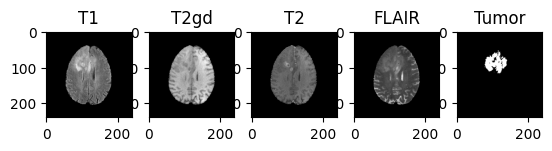

In [ ]:
batch_size = 1
dataset = BrainImageDataset(root_dir)
# split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# compute class weights

fig, ax = plt.subplots(1, 5)
num  = 10
ax[0].imshow(train_dataset[num]["image"][0], cmap="gray")
ax[0].set_title("T1")
ax[1].imshow(train_dataset[num]["image"][1], cmap="gray")
ax[1].set_title("T2gd")
ax[2].imshow(train_dataset[num]["image"][2], cmap="gray")
ax[2].set_title("T2")
ax[3].imshow(train_dataset[num]["image"][3], cmap="gray")
ax[3].set_title("FLAIR")
ax[4].imshow(train_dataset[num]["label"], cmap="gray")
ax[4].set_title("Tumor")
if train_dataset[num]["class"] == 0:
    print("Low Risk")
else:
    print("High Risk")

Text(0.5, 1.0, 'ReLu activation')

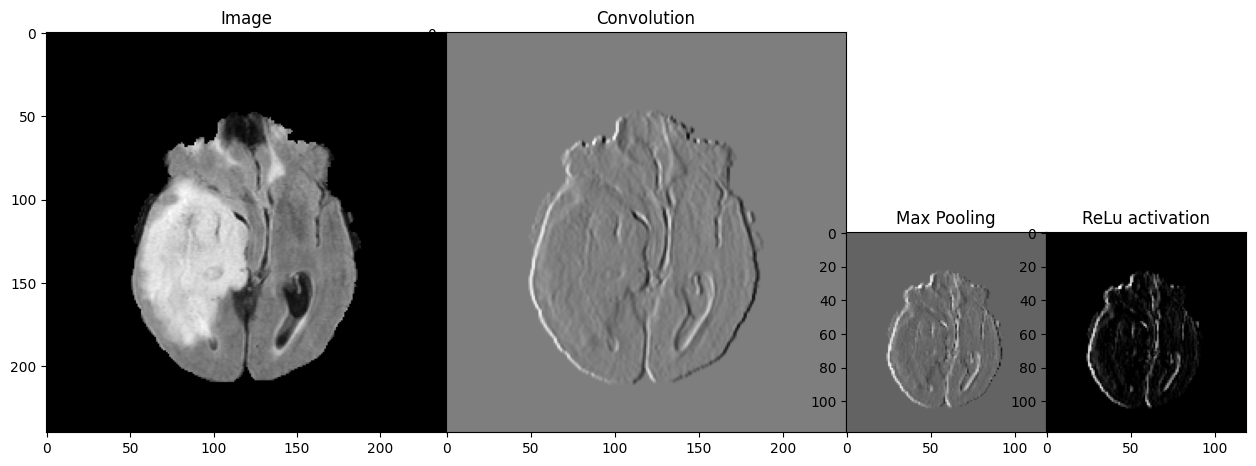

In [ ]:
# Basic building blocks:

image = train_dataset[num]["image"][0]
kernel = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
image_conv = F.conv2d(image.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0))
image_max_pool = F.max_pool2d(image_conv, 2)
image_ReLu = F.relu(image_max_pool)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.4])
ax2 = fig.add_axes([0.5, 0.1, 0.4, 0.4])
ax3 = fig.add_axes([0.9, 0.1, 0.2, 0.2])
ax4 = fig.add_axes([1.1, 0.1, 0.2, 0.2])

ax1.imshow(image, cmap='gray')
ax1.set_title("Image")
ax2.imshow(image_conv[0][0], cmap='gray')
ax2.set_title("Convolution")
ax3.imshow(image_max_pool[0][0], cmap='gray')
ax3.set_title("Max Pooling")
ax4.imshow(image_ReLu[0][0], cmap='gray')
ax4.set_title("ReLu activation")

In [ ]:
class UNetDown_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNetDown_block, self).__init__()
    # INSERT CODE HERE


  def forward(self, x):
    # INSERT CODE HERE
    return x


class Encoder(nn.Module):
  def __init__(self,in_channels, num_classes):
    super(Encoder, self).__init__()
    # INSERT CODE HERE

  def forward(self, x):
    # INSERT CODE HERE
    return x


In [ ]:
class DefaultTrainer():
  """
  Default trainer class for training and validation of a neural network model.
  """
  def __init__(self, model, train_loader, validation_loader, criterion, optimizer, device):
    """
    Constructor method for initializing the trainer.

    Args:
        model: Neural network model to be trained.
        train_loader: DataLoader for training data.
        validation_loader: DataLoader for validation data.
        criterion: Loss criterion.
        optimizer: Optimization algorithm.
        device: Device to perform computations (e.g., 'cuda' for GPU or 'cpu').
    """
    self.model = model
    self.train_loader = train_loader
    self.validation_loader = validation_loader
    self.criterion = criterion
    self.optimizer = optimizer
    self.device = device

  def train(self, current_epoch):
    """
    Method to train the model for one epoch.

    Args:
        current_epoch (int): Current epoch number.
    """
    self.model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
      inputs, classes = data["image"].to(device), data["class"].to(device)
      self.optimizer.zero_grad()
      outputs = self.model(inputs)
      loss = self.criterion(outputs, classes)
      loss.backward()
      self.optimizer.step()
      running_loss += loss.item()
    print(f"Epoch: {current_epoch}, Batch: {i}, Loss: {running_loss/(i+1)}")

  def validate(self):
    """
    Method to validate the model on the validation dataset.
    """
    test_accuracy = 0
    self.model.eval()
    with torch.no_grad():
      for i, data in enumerate(self.validation_loader):
        inputs, classes = data["image"].to(device), data["class"].to(device)
        outputs = self.model(inputs)
        outputs = outputs.argmax(dim=1)
        test_accuracy += (outputs == classes).sum()

    data_num = len(self.validation_loader)*batch_size
    print(f"Test Accuracy: {test_accuracy/data_num* 100}")
    return test_accuracy/data_num* 100

  def save_model(self, path):
    """
    Method to save the trained model to a file.

    Args:
        path (str): Path to save the model.
    """
    torch.save(self.model.state_dict(), path)
    print("Model saved")

  def load_model(self, path):
    """
    Method to load a trained model from a file.

    Args:
        path (str): Path to the saved model.
    """
    self.model.load_state_dict(torch.load(path))

  def init_weights(self):
    """
    Method to initialize the weights of the model.
    """
    def init_weights(m):
      if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    self.model.apply(init_weights)

In [ ]:
import torch.optim as optim
torch.manual_seed(0)
net = Encoder(4,2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

best_accuracy = 0
num_epochs = 20

trainer = DefaultTrainer(net, train_loader, test_loader, criterion, optimizer, device)
trainer.init_weights()
for epoch in range(num_epochs):
  # INSERT CODE HERE


In [ ]:
# Run validation of the model

running_accuracy = 0
net.load_state_dict(torch.load("best_classification_model.pth"))
net.eval()
data_num = len(test_loader)*batch_size
with torch.no_grad():
  for i, data in enumerate(test_loader):
    inputs, classes = data["image"].to(device), data["class"].to(device)
    outputs = net(inputs)
    outputs = outputs.argmax(dim=1)
    running_accuracy += (outputs == classes).sum()

print(f"Accuracy: {running_accuracy/data_num * 100}")

Accuracy: 73.68421173095703


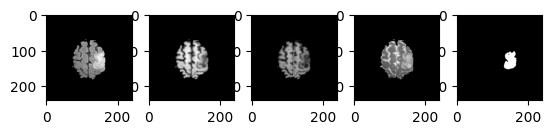

In [ ]:
fig, ax = plt.subplots(1, 5)
num  = 10
ax[0].imshow(train_dataset[num]["image"][0], cmap='gray')
ax[1].imshow(train_dataset[num]["image"][1], cmap='gray')
ax[2].imshow(train_dataset[num]["image"][2], cmap='gray')
ax[3].imshow(train_dataset[num]["image"][3], cmap='gray')
ax[4].imshow(train_dataset[num]["label"], cmap='gray')

In [ ]:
class UNetUp_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNetUp_block, self).__init__()
    # INSERT CODE HERE

  def forward(self, x1, x2):
    # INSERT CODE HERE
    return x1



class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet, self).__init__()
    self.down1 = UNetDown_block(in_channels, 64)
    self.down2 = UNetDown_block(64, 128)
    self.down3 = UNetDown_block(128, 256)
    self.down4 = UNetDown_block(256, 512)

    # INSERT CODE HERE

  def forward(self, x):
    # INSERT CODE HERE
    return x



def DiceMetric(pred, target):
  """
  Compute the Dice coefficient as a metric.

  Args:
      pred (torch.Tensor): Predicted values.
      target (torch.Tensor): Ground truth values.

  Returns:
      torch.Tensor: Dice coefficient.
  """

  pred = torch.sigmoid(pred)
  pred = (pred > 0.5).float()

  target = torch.sigmoid(target)
  target = (target > 0.5).float()

  intersection = (pred * target).sum()
  dice = (2 * intersection) / (pred.sum() + target.sum())
  return dice

def DiceLoss(pred, target):

  """
  Compute the Dice loss.

  Args:
      pred (torch.Tensor): Predicted values.
      target (torch.Tensor): Ground truth values.

  Returns:
      torch.Tensor: Dice loss.
  """
  pred = torch.sigmoid(pred)
  intersection = (pred * target).sum()
  dice = (2 * intersection) / (pred.sum() + target.sum())
  return 1 - dice

def BCE_Dice_Loss(pred, target):

  """
  Compute the combination of Binary Cross Entropy (BCE) loss and Dice loss.

  Args:
      pred (torch.Tensor): Predicted values.
      target (torch.Tensor): Ground truth values.

  Returns:
      torch.Tensor: Combined loss.
  """
  dice = DiceLoss(pred, target)
  bce = nn.BCEWithLogitsLoss()(pred, target)
  return bce + dice

In [ ]:
class SegmentationTrainer(DefaultTrainer):
    def __init__(self, model, train_loader, validation_loader, criterion, optimizer, device):
        super().__init__(model, train_loader, validation_loader, criterion, optimizer, device)

    def train(self, current_epoch):
        self.model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data["image"].to(device), data["label"].to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            outputs.squeeze_(1)
            loss = BCE_Dice_Loss(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        print(f"Epoch: {current_epoch}, Batch: {i}, Loss: {running_loss/(i+1)}")

    def validate(self):
        test_accuracy = 0
        self.model.eval()
        with torch.no_grad():
            for i, data in enumerate(self.validation_loader):
                inputs, labels = data["image"].to(device), data["label"].to(device)
                outputs = self.model(inputs)
                outputs.squeeze_(1)
                test_accuracy += DiceMetric(outputs, labels)
        data_num = len(self.validation_loader)*batch_size
        print(f"Test Accuracy: {test_accuracy/data_num}")
        return test_accuracy/data_num



In [ ]:
torch.manual_seed(0)
net = UNet(4, 1).to(device)

loss_function = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
best_metric = 0
num_epochs = 200


trainer = SegmentationTrainer(net, train_loader, test_loader, loss_function, optimizer, device)
for epoch in range(num_epochs):
  # INSERT CODE HERE


In [ ]:
n = 0


net.load_state_dict(torch.load("best_segmentation_model.pth"))
testing_input = dataset[n]["image"].unsqueeze(0).to(device)
test = net(testing_input)


fig, ax = plt.subplots(1, 2)
test = torch.sigmoid(test)
test = (test > 0.5).float()

ax[0].imshow(dataset[n]["label"])
ax[1].imshow(test.squeeze_().cpu().detach().numpy())
print(test.shape, dataset[n]["label"].shape)
print(torch.unique(test), torch.unique(dataset[n]["label"]))

print(DiceMetric(test, dataset[n]["label"].to(device)))